In [1]:
# First we import all the libraries required for basic data manipulation
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Import our csv files as DataFrames
SP500 = pd.read_csv('SP500_2.csv', parse_dates=True)
Nasdaq = pd.read_csv('Nasdaq_2.csv', parse_dates=True)
DJI = pd.read_csv('DJI_2.csv', parse_dates=True)
DAX = pd.read_csv('DAX_2.csv', parse_dates=True)
Paris = pd.read_csv('Paris_2.csv', parse_dates=True)
Tokyo = pd.read_csv('Tokyo_2.csv', parse_dates=True)
HongKong = pd.read_csv('HongKong_2.csv', parse_dates=True)
Aus = pd.read_csv('Aus_2.csv', parse_dates=True)

In [3]:
# Create our target variable, which is tomorrow's Adj Close
target_raw = (SP500['Adj Close'].shift(-1)/SP500['Adj Close'])-1

In [4]:
# View first 10 rows of our target array
target_raw.head()

0    0.001686
1   -0.001410
2   -0.002664
3    0.001918
4   -0.007087
Name: Adj Close, dtype: float64

In [5]:
# This will be useful later
datasets = [SP500, Nasdaq, DJI, DAX, Paris, Tokyo, HongKong, Aus]
names = ['SP500', 'Nasdaq', 'DJI', 'DAX', 'Paris', 'Tokyo', 'HongKong', 'Aus']

In [6]:
# We define the generate_features() function for our feature engineering
"""
The generate_features function performs feature engineering using Adj Close only. The features generated are Daily Returns, 
Momentum (Daily Returns over 2 days), Daily Return SMA and lagging Daily Returns

Since we had some "null" values in our DataFrames previously, the DataFrames columns are still considered strings,
we need to change that by changing the values to floats
"""


def generate_features(datasets, DR, DR_SMA, Lagging):
    Max = max(DR, DR_SMA, Lagging+1)
    for i in range(len(datasets)):
        dataset = datasets[i]
        name = names[i]
        for j in range(1, DR+1):
            dataset[name+'_'+str(j)+'DailyReturn'] = (dataset['Adj Close'].astype(float)/dataset['Adj Close'].astype(float).shift(j))-1
        for k in range(2, DR_SMA+1):
            dataset[name+'_'+str(k)+'DR_SMA'] = pd.rolling_mean(dataset[name+'_'+str(1)+'DailyReturn'], window=k)
        for l in range(1, Lagging+1):
            dataset[name+'_'+str(l)+'LaggingDays'] = dataset[name+'_'+str(1)+'DailyReturn'].shift(l)
        dataset.drop(dataset.index[:Max], inplace=True)
    return Max

In [7]:
# We define the merge_datasets() function to merge all DataFrames
"""
After feature engineering, merge all datasets and drop the 'useless' features. We are only using those features generating
using Adj Close, therefore all the other columns are not relevant and need to be removed
"""
def merge_datasets(datasets):
    drop_features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Date']
    for i in range(len(datasets)):
        datasets[i] = datasets[i].drop(drop_features, axis=1)
    megaset = pd.concat(datasets, axis=1)
    return megaset

In [8]:
# Using the above two functions to do feature engineering (note that some warning messages will appear due to version control)
generate_features(datasets, 20, 20, 20)
megaset = merge_datasets(datasets)

C:\Users\Leslie\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=2,center=False).mean()
C:\Users\Leslie\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()
C:\Users\Leslie\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).mean()
C:\Users\Leslie\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
C:\Users\Leslie\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: pd.roll

In [9]:
print("Our new dataset has {}".format(megaset.shape[0]), "rows and {}".format(megaset.shape[1]), "columns")

Our new dataset has 6232 rows and 472 columns


In [10]:
# Create our target variable and binary encode the array, 1 for DR increase, 0 for DR decrease/no change
target = target_raw[21:]
target[target > 0] = 1
target[target <= 0] = 0

In [11]:
print("Our target has {} values".format(target.shape[0]))

Our target has 6232 values


In [12]:
# Principal Component Analysis (PCA) to reduce number of features
"""
Since we now have 472 features, we should reduce the number of features to optimise the training process.
Therefore we import the required library for PCA.
"""
from sklearn.decomposition import PCA

In [13]:
# We apply PCA by fitting the data with only 10 dimensions (components)
pca = PCA(n_components = 10)
pca.fit(megaset)
print(pca.explained_variance_ratio_)
print("Our reduced dimensions can explain {:.4f}".format(sum(pca.explained_variance_ratio_)),
      "% of the variance in the original data")

[ 0.48869068  0.07465375  0.06444006  0.05478051  0.04107006  0.0268381
  0.02263792  0.0175183   0.01596123  0.01116243]
Our reduced dimensions can explain 0.8178 % of the variance in the original data


In [14]:
# We create a new DataFrame with these 10 new PCA components
reduced_megaset = pca.transform(megaset)
reduced_megaset = pd.DataFrame(reduced_megaset, columns = ['Dimension 1', 'Dimension 2',
                                                           'Dimension 3', 'Dimension 4',
                                                           'Dimension 5', 'Dimension 6',
                                                           'Dimension 7', 'Dimension 8',
                                                           'Dimension 9', 'Dimension 10'])

In [15]:
# Let's have a look at the new feature DataFrame
reduced_megaset.head()

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,Dimension 10
0,-0.070869,-0.175132,0.188538,-0.091503,-0.120237,0.038997,-0.099127,-0.007584,-0.032180,0.012546
1,-0.107387,-0.152888,0.138574,-0.054370,-0.104608,0.038989,-0.082913,0.002462,-0.013329,-0.013628
2,-0.047233,-0.192850,0.093440,-0.040650,-0.087376,0.046411,-0.056184,0.026102,-0.014609,-0.014664
3,-0.058944,-0.079337,-0.048917,0.025640,-0.074347,0.037915,-0.030072,0.052715,-0.010731,-0.006141
4,-0.033568,-0.035606,-0.072818,0.003258,-0.084036,0.033549,-0.009099,0.055372,-0.002367,0.014600


In [16]:
# We can visualise the PCA-transformed components' culmulative explained variance
pca = PCA().fit(megaset)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

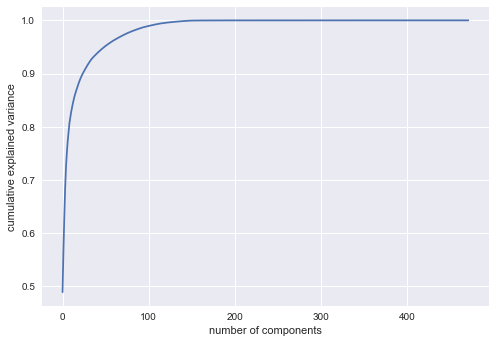

In [17]:
plt.show()

In [18]:
# We split our dimension-reduced megaset into training and cross-validation (test) subsets
"""
Hmmm...looks like the sweet spot is around 50 PCA components but let's stick with 10 for now.
The 6,001st row marks the 17th Oct 2016 which is exactly one year before the commencement of this project, we will use this
last final year as our cross-validation set
"""
X_train = reduced_megaset[:6001]
X_test = reduced_megaset[6001:-1]
y_train = target[:6001]
y_test = target[6001:-1]

In [19]:
# Export our newly created reduced_megaset as CSV files to the working directory
reduced_megaset.to_csv('reduced_megaset.csv', index=False)